In [1]:
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchaudio

from IPython.display import Audio, display

import utils
import net
import loss

import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device('cuda')
transform = torchaudio.transforms.InverseSpectrogram().to(device=device)

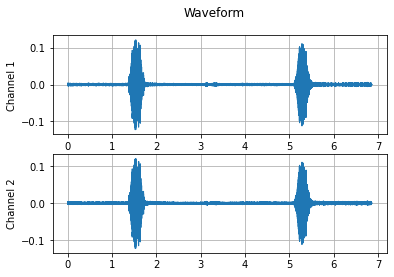

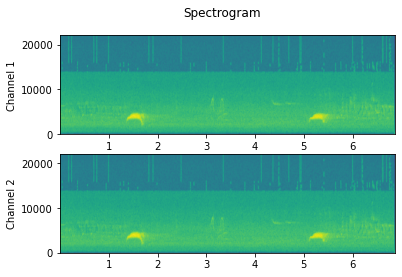

In [3]:
target, sr, dim = utils.load_spec('data/western_wood_pewee_original.wav')
target = target.to(device=device)

In [4]:
model = net.FeatureNet(2, device)
model.requires_grad_(True)

FeatureNet(
  (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(2, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(2, 32, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(2, 32, kernel_size=(11, 11), stride=(1, 1), padding=(4, 4))
  (conv5): Conv2d(2, 32, kernel_size=(15, 15), stride=(1, 1), padding=(6, 6))
  (conv6): Conv2d(2, 32, kernel_size=(19, 19), stride=(1, 1), padding=(8, 8))
  (conv7): Conv2d(2, 32, kernel_size=(23, 23), stride=(1, 1), padding=(10, 10))
  (conv8): Conv2d(2, 32, kernel_size=(27, 27), stride=(1, 1), padding=(12, 12))
  (relu): ReLU()
)

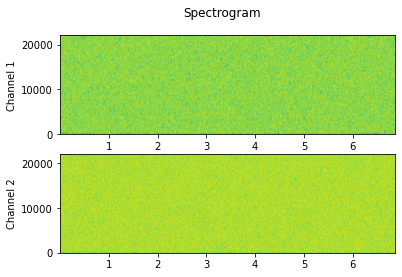

In [5]:
noise = (utils.generate_white_noise(target.contiguous().type(torch.FloatTensor)
                                    .to(device=device), device)
         .requires_grad_(True).to(device=device))

waveform = transform(noise.squeeze(0).type(torch.complex64))
utils.plot_specgram(waveform.detach().cpu(), sr)

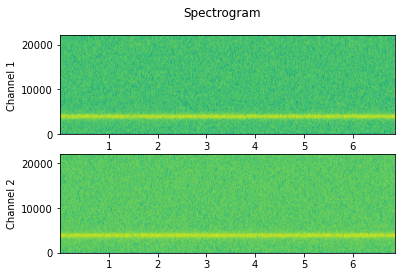

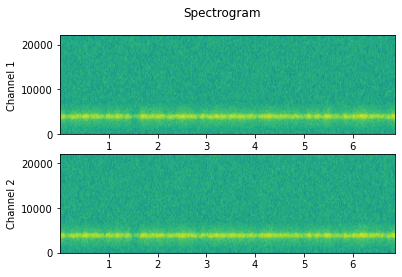

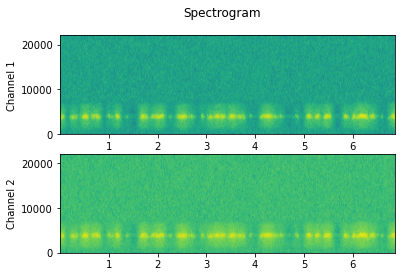

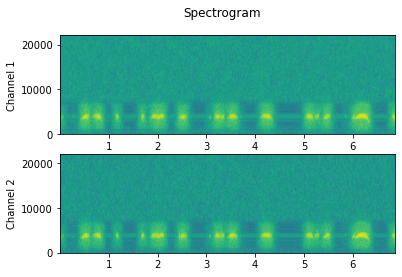

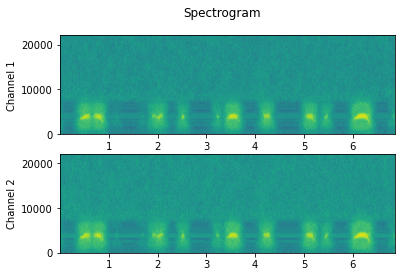

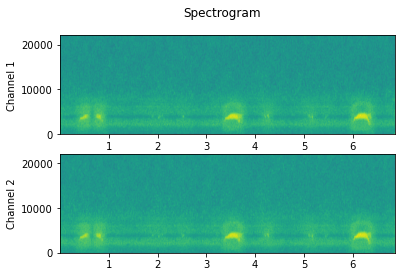

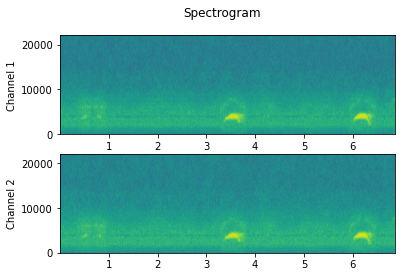

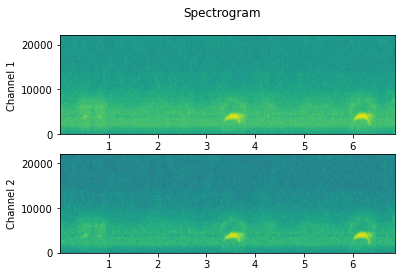

In [6]:
optimizer = optim.Adam([noise])

target_activations = model(target.type(torch.FloatTensor).to(device=device))
texture_loss = loss.TextureLoss(target_activations)

epoch = 0

prev_loss = 100

stop = False
while not stop:
    
    epoch += 1
    
    def closure():
        
        global prev_loss
        global stop
        
        optimizer.zero_grad()
        
        activations = model(noise)

        loss = texture_loss.forward(activations)
        
        if epoch % 100 == 0:
            
            if (prev_loss - loss.item()) < 0.0005:
                stop = True
            else:
                prev_loss = loss.item()
            
        loss.backward(retain_graph=True)
        
        return loss

    optimizer.step(closure)
    
    if epoch % 1000 == 0 and epoch != 0:
    
        waveform = transform(noise.squeeze(0).type(torch.complex64))
        utils.plot_specgram(waveform.detach().cpu(), sr)
    
    if stop:
        waveform = transform(noise.squeeze(0).type(torch.complex64))
        utils.plot_specgram(waveform.detach().cpu(), sr)
    

In [7]:
utils.play_audio(waveform.detach().cpu(), sr)